In [1]:
library(Seurat)
library(data.table)
library(ggplot2)
library(flexclust)

Attaching SeuratObject

Loading required package: grid

Loading required package: lattice

Loading required package: modeltools

Loading required package: stats4



In [2]:
datasetName = 'Placenta_ChorionicVillus_Guo2020'
#datasetName value: organ_tissue_authorYear without space
dataFormat = 'tsv'
#dataFormat value: tsv (tab separated), 10X (sparse)
setwd("/stor/public/hcad/db_v1/Placenta_ChorionicVillus_Guo2020/")

In [3]:
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- read.table(paste0(datasetName,"_expression.tsv.gz"), h = T, row.names = 1)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tar.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}

In [4]:
data.matrix <- data.matrix[, -1]
data.matrix[1:5, 1:5]
data.metadata[1:5, ]
data.annotation[1:5,]

,ChorionicVillus_1.TGATCAGGGTTTCGGCAG,ChorionicVillus_1.GAACGCGCTGTGCCTAGA,ChorionicVillus_1.ACGAGCTGCAATCGCACC,ChorionicVillus_1.CATCCCGAATTAACGTTG,ChorionicVillus_1.ACACCCTACTTCTCAAAG
,<int>,<int>,<int>,<int>,<int>
A1BG-AS1,0,0,0,0,0
A2M,0,0,1,0,0
A2M-AS1,0,0,0,0,0
A2MP1,0,0,0,0,0
A4GALT,0,0,0,0,0


,organ,region,subregion,sample_status,donor_ID,donor_gender,donor_age
,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
ChorionicVillus_1.ACCTGATACTTCCGTGGC,Chorionic Villus,ChorionicVillus,ChorionicVillus,normal,Donor3,male,13 week old
ChorionicVillus_1.TGATCAGGGTTTCGGCAG,Chorionic Villus,ChorionicVillus,ChorionicVillus,normal,Donor3,male,13 week old
ChorionicVillus_1.GAACGCGCTGTGCCTAGA,Chorionic Villus,ChorionicVillus,ChorionicVillus,normal,Donor3,male,13 week old
ChorionicVillus_1.ACGAGCTGCAATCGCACC,Chorionic Villus,ChorionicVillus,ChorionicVillus,normal,Donor3,male,13 week old
ChorionicVillus_1.CATCCCGAATTAACGTTG,Chorionic Villus,ChorionicVillus,ChorionicVillus,normal,Donor3,male,13 week old


[1] "Macrophage"      "Epithelial cell" NA                "Macrophage"     
[5] "Epithelial cell"

In [5]:
# Pre-processing
min.cells = 3
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.cells = min.cells, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}

Warning message in CreateSeuratObject.default(counts = data.matrix, project = datasetName, :
“Some cells in meta.data not present in provided counts matrix”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


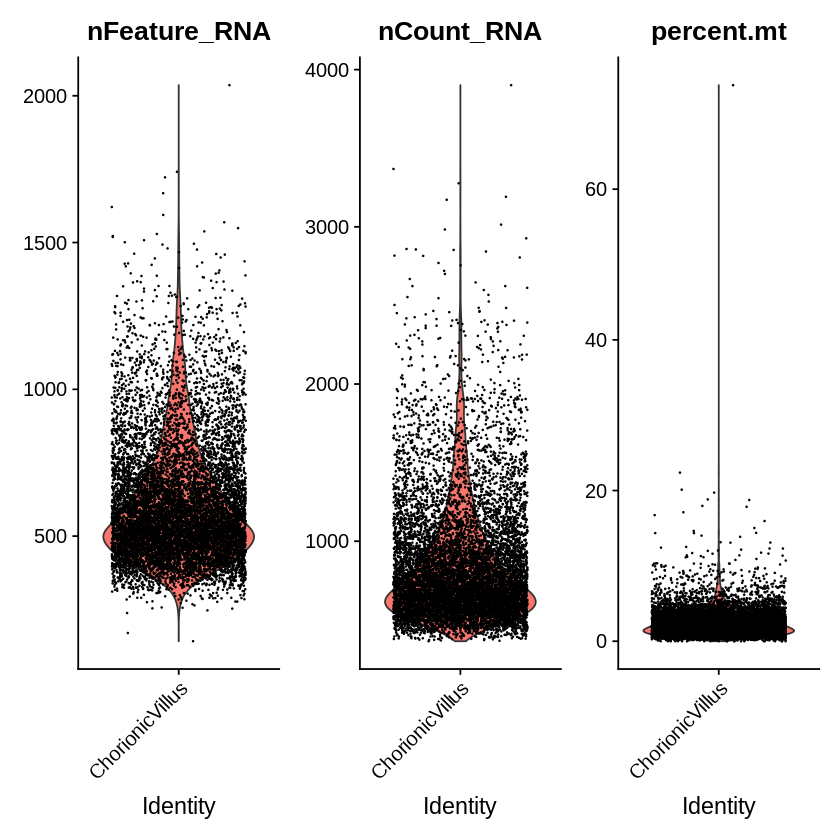

In [6]:
VlnPlot(dataobj, features = c('nFeature_RNA', 'nCount_RNA', 'percent.mt'), ncol = 3)

In [9]:
# QC
nFeature_RNA_range = c(200, 1500)
percent.mt.thre = 10
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)

In [10]:
# Normalization
# Two approaches
# 1. run standard log normalization 
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj <- FindVariableFeatures(dataobj, selection.method = 'vst', nfeatures = 2000) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

Centering and scaling data matrix



In [11]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj))
# Determine the ‘dimensionality’ of the dataset according to elbow plot

PC_ 1 
Positive:  KRT19, KRT18, TFPI, FSTL3, QSOX1, LY6E, LAIR2, EFNA1, TMSB10, MFAP5 
	   HTRA4, GPX3, ITGA5, PDIA6, ISM2, CDKN1C, PFN1, GJA5, PGF, ANXA1 
	   HPGD, EBI3, SRI, BZW2, PDIA5, ANXA2, C12orf75, XAGE2, PRSS8, LGALS3BP 
Negative:  TMSB4X, FTL, SPP1, CCL3, LAPTM5, CTSD, CD74, GPNMB, GLUL, CCL4 
	   CCL4L2, FTLP3, CTSB, CD14, CXCL8, HLA-DRA, CXCL2, SOD2, VIM, DAB2 
	   CCL3L3, RNASE1, CTSS, HLA-DRB1, F13A1, SEPP1, BCL2A1, HLA-B, IER3, C1QB 
PC_ 2 
Positive:  B2M, CD74, PSAP, FTH1, CTSB, FTL, HLA-DRB1, S100A11, HLA-DRA, FTLP3 
	   CXCL2, APOC1, CXCL3, NFKBIA, HLA-DPB1, GPR183, HLA-DMA, PLAUR, SAT1, CTSD 
	   HLA-DPA1, SOD2, SDS, RGS1, LAPTM5, G0S2, C15orf48, PLIN2, LYZ, GPNMB 
Negative:  COL1A1, COL3A1, DLK1, DCN, LUM, EGFL6, CXCL14, COL1A2, COL6A2, ACTA2 
	   HAPLN1, COL6A1, MEST, HGF, GPC3, WNT2, TAGLN, CDH11, COL5A1, GJA1 
	   COL15A1, COL14A1, PITX2, VCAN, LAMA2, PLPP3, COL5A2, CTHRC1, COL6A3, FBLN2 
PC_ 3 
Positive:  CD74, PSAP, B2M, HLA-DRB1, HLA-DRA, CXCL3, APOC1, FTH1, 

Warning message in ElbowPlot(dataobj, ndims = 100):
“The object only has information for 50 reductions”


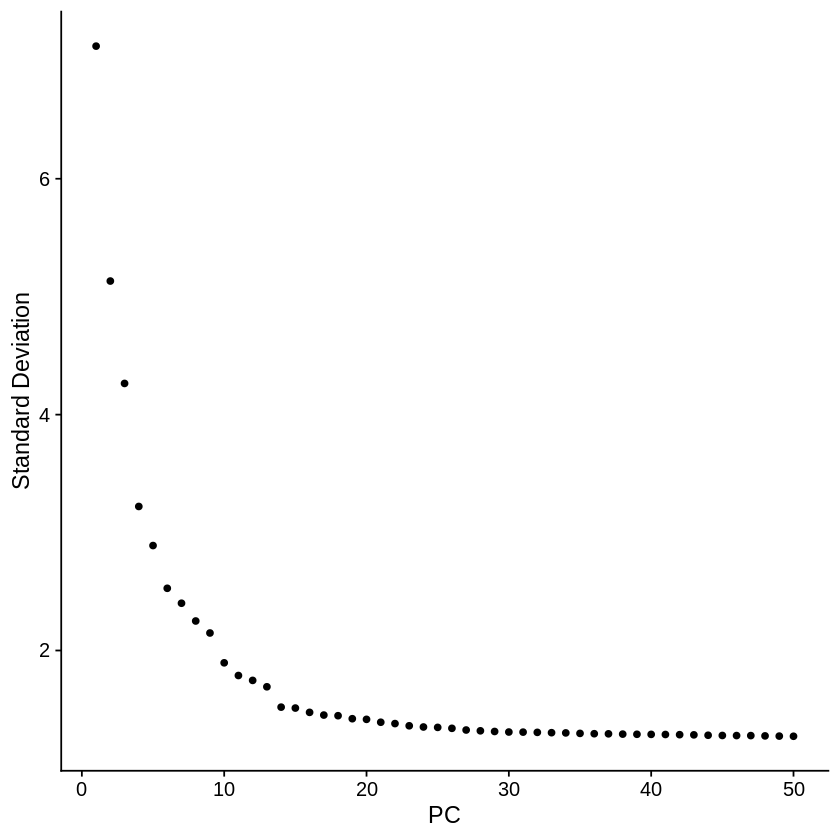

In [12]:
ElbowPlot(dataobj, ndims=100) 
# pdf(paste0(datasetName,"seurat.elbowplot.pdf"))

In [13]:
dev.off()
pcDim = 10 # set as 14 in this case 
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)
DimPlot(dataobj, reduction = "umap", label = TRUE)
# ggsave(paste0(datasetName,".seurat.umap.tiff", plot = p_umap, width = 8, height = 5)

null device 
          1

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
17:26:02 UMAP embedding parameters a = 0.9922 b = 1.112

17:26:02 Read 9911 rows and found 10 numeric columns

17:26:02 Using Annoy for neighbor search, n_neighbors = 30

17:26:02 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:26:03 Writing NN index file to temp file /tmp/Rtmp9o9O5R/filed7d4ae50f9f

17:26:03 Searching Annoy index using 1 thread, search_k = 3000

17:26:06 Annoy recall = 100%

17:26:06 Commencing smooth kNN distance calibration using 1 thread

17:26:07 Initializing from

In [26]:
# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)
dataobj <- FindClusters(dataobj, resolution = 0.03)
# umap
dataobj <- RunUMAP(dataobj, dims = 1:pcDim)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 9911
Number of edges: 328647

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9838
Number of communities: 4
Elapsed time: 1 seconds


17:33:58 UMAP embedding parameters a = 0.9922 b = 1.112

17:33:58 Read 9911 rows and found 10 numeric columns

17:33:58 Using Annoy for neighbor search, n_neighbors = 30

17:33:58 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

17:33:59 Writing NN index file to temp file /tmp/Rtmp9o9O5R/filed7d6bf6d403

17:33:59 Searching Annoy index using 1 thread, search_k = 3000

17:34:02 Annoy recall = 100%

17:34:02 Commencing smooth kNN distance calibration using 1 thread

17:34:02 Initializing from normalized Laplacian + noise

17:34:03 Commencing optimization for 500 epochs, with 419540 positive edges

17:34:26 Optimization finished



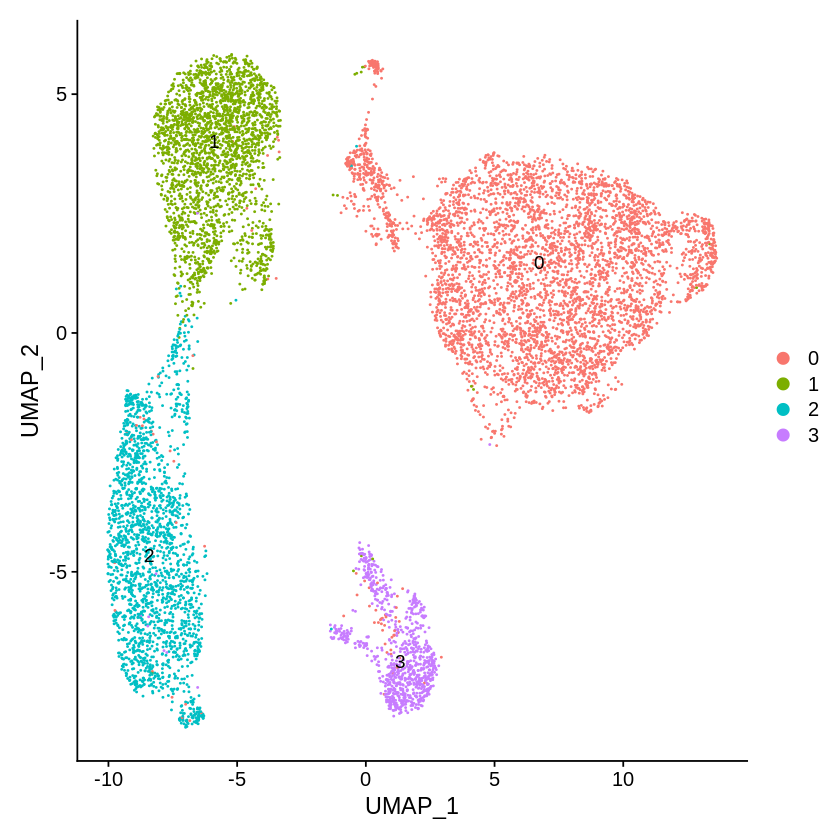

In [27]:
p_umap <- DimPlot(dataobj, reduction = "umap", label = TRUE)
p_umap

In [22]:
#ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)

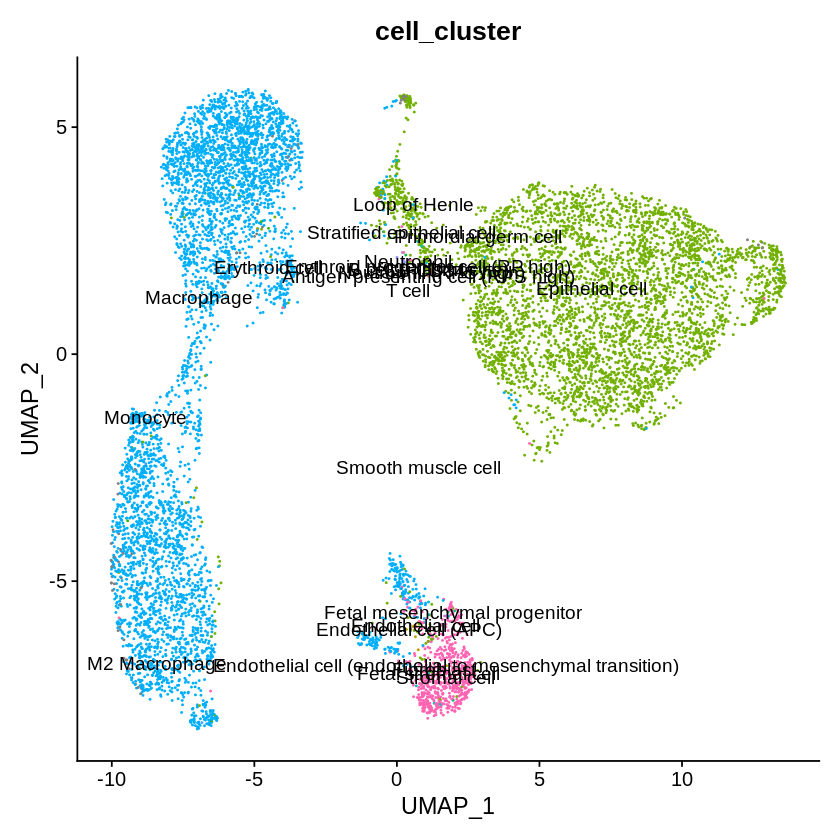

In [28]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE, group.by = "cell_cluster") + NoLegend()
p_umap2

In [29]:
#ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)

In [30]:
# Finding cluster markers 
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE, min.pct = 0.25, logfc.threshold = 0.25)
write.table(dataobj.markers, file = paste0(datasetName,".__seurat.markers.v1.1.txt"), sep = "\t", quote = F, row.names = F, col.names = T)

Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3



In [31]:
new.cluster.ids <- c("Placenta-Epithelial tissue-Epithelial cell-KRT8 KRT19 KRT18",
                     "Placenta-Connective tissue-Erythrocyte-HBG2 AHSP",
                     "Placenta-Connective tissue-Macrophage-CD14 CD74",
                     "Placenta-Connective tissue-Stromal cell/Macrophage-COL3A1 COL1A1 DCN/CD14 CD74"
                    )
names(new.cluster.ids) <- levels(dataobj)
dataobj <- RenameIdents(dataobj, new.cluster.ids)

In [32]:
#ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap2, width = 8, height = 5)

In [33]:
#saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

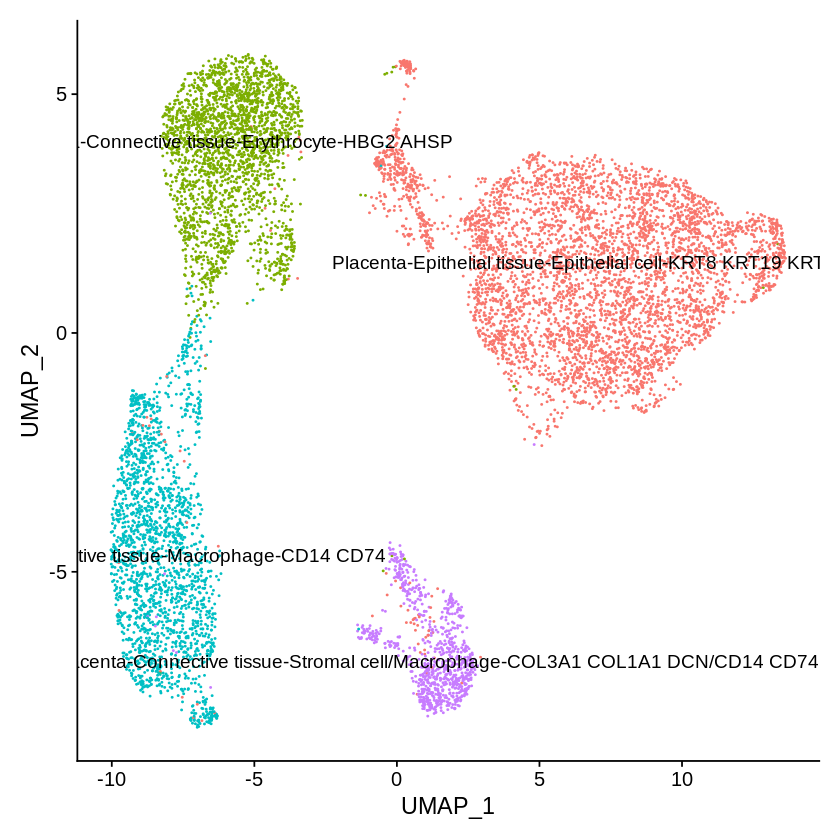

In [34]:
pp_umap2 <- DimPlot(dataobj, reduction = "umap", label = TRUE)+ NoLegend()
pp_umap2

In [79]:
#saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))